# View Scenario Areas

This prints out a list of areas used in the scenarios together with the bounding boxes.

First, lets import everything we need:

In [89]:
import os
import glob
from statistics import mean
from functools import partial

import pyproj
import geopandas as gpd
import plotly.graph_objects as go

from IPython.display import HTML
from shapely.geometry import Polygon, Point
from shapely.ops import transform

## Scan folders

Then we define the folder structure and scan these for `.scn` files that contain the operator used to create aircrafts in `BlueSky`:

In [41]:
SEARCH_OPERATOR = ['POLY', 'CIRCLE']

scenario_files = os.path.join('..', '..', 'scenario', '**', '*.scn')
lines = []
for scenario_file in glob.glob(scenario_files, recursive=True):
    with open(scenario_file) as f:
        lines.extend([(scenario_file, line) for line in f.readlines() if any(map(line.__contains__, SEARCH_OPERATOR))])
print(f'Found {len(lines)} area definitions at "{scenario_files}"')

Found 14 area definitions at "..\..\scenario\**\*.scn"


## Extract areas

Each of these lines is then split according to the command definition to extract the names and types of areas used:

In [84]:
P = pyproj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
G = pyproj.Geod(ellps='WGS84')

areas = []
for line in lines:
    scen = line[0]
    line = line[1].strip().split()
    type, name, coords = line[1].lower(), line[2], line[3:]
    if type == "poly":
        geo = Polygon([tuple(map(float, p)) for p in zip(coords[::2], coords[1::2])])
    elif type == "circle":
        lat, lon = float(coords[0]), float(coords[1])
        radius = float(coords[2]) * 1852
        # TODO project
        geo = Point([float(c) for c in coords[:2]]).buffer(radius)
    areas.append({
        "scenario": scen,
        "lon": mean([p[1] for p in geo.exterior.coords]),
        "lat": mean([p[0] for p in geo.exterior.coords]),
        "type": type,
        "name": name,
        "geometry": geo
    })
gdf = gpd.GeoDataFrame(areas)

## Output

Finally, the `DataFrame` is converted to an `HTML` output:

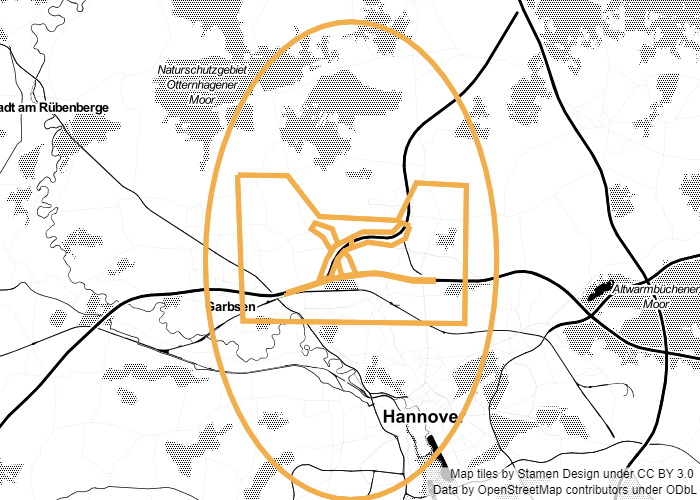

In [87]:
polys = []
for index, row in gdf.iterrows():
    poly = row.geometry
    plot = go.Scattermapbox(
        lon=list([p[1] for p in poly.exterior.coords]),
        lat=list([p[0] for p in poly.exterior.coords]),
        mode='lines',
        line_color='#f2ae4b',
        line_width=5
    )
    polys.append(plot)


fig = go.Figure(data=polys)
fig.update_mapboxes(
    style='stamen-toner',
    center_lon=gdf.lon.mean(),
    center_lat=gdf.lat.mean(),
    zoom=10,    
)
fig.update_layout(
    showlegend=False, 
    margin=dict(t=0, l=0, r=0, b=0),
    template="plotly_white"
)
fig.show("png")

In [67]:
HTML(gdf.to_html(escape=False))

,scenario,type,name,geometry
0,..\..\scenario\usepe_e3_ref.scn,poly,Traffic_area,"POLYGON ((52.47166 9.60535, 52.47137 9.63983, 52.45426 9.66161, 52.45264 9.71544, 52.46835 9.72814, 52.46724 9.76250, 52.40947 9.76138, 52.41055 9.60913, 52.47166 9.60535))"
1,..\..\scenario\usepe_exercise2_reference.scn,poly,Traffic_area,"POLYGON ((52.47166 9.60535, 52.47137 9.63983, 52.45426 9.66161, 52.45264 9.71544, 52.46835 9.72814, 52.46724 9.76250, 52.40947 9.76138, 52.41055 9.60913, 52.47166 9.60535))"
2,..\..\scenario\USEPE\exercise_2\operation_areas.scn,poly,Op1,"POLYGON ((52.45032 9.72381, 52.45172 9.71804, 52.44777 9.71182, 52.44786 9.69135, 52.44547 9.68339, 52.44127 9.68405, 52.44355 9.69491, 52.44214 9.71134, 52.44501 9.72055, 52.45032 9.72381))"
3,..\..\scenario\USEPE\exercise_2\operation_areas.scn,poly,Op2,"POLYGON ((52.44127 9.68405, 52.44547 9.68339, 52.44185 9.67205, 52.43643 9.66658, 52.42838 9.66173, 52.42852 9.66894, 52.43654 9.67402, 52.44000 9.67909, 52.44127 9.68405))"
4,..\..\scenario\USEPE\exercise_2\operation_areas.scn,poly,Op3,"POLYGON ((52.44185 9.67205, 52.44264 9.67441, 52.44915 9.67038, 52.45163 9.65860, 52.44902 9.65603, 52.44563 9.66413, 52.43977 9.66992, 52.44185 9.67205))"
5,..\..\scenario\USEPE\exercise_2\operation_areas.scn,poly,Op4,"POLYGON ((52.43654 9.67402, 52.43958 9.67849, 52.43724 9.68201, 52.43011 9.68675, 52.42935 9.67738, 52.43105 9.67620, 52.43654 9.67402))"
6,..\..\scenario\USEPE\exercise_2\operation_areas.scn,circle,Op5,"POLYGON ((52.53572 9.68334, 52.53524 9.67354, 52.53380 9.66383, 52.53141 9.65431, 52.52811 9.64507, 52.52391 9.63620, 52.51887 9.62778, 52.51302 9.61990, 52.50643 9.61263, 52.49916 9.60604, 52.49128 9.60019, 52.48286 9.59515, 52.47399 9.59095, 52.46475 9.58765, 52.45523 9.58526, 52.44552 9.58382, 52.43572 9.58334, 52.42592 9.58382, 52.41621 9.58526, 52.40669 9.58765, 52.39745 9.59095, 52.38858 9.59515, 52.38016 9.60019, 52.37228 9.60604, 52.36501 9.61263, 52.35842 9.61990, 52.35257 9.62778, 52.34753 9.63620, 52.34333 9.64507, 52.34003 9.65431, 52.33764 9.66383, 52.33620 9.67354, 52.33572 9.68334, 52.33620 9.69314, 52.33764 9.70285, 52.34003 9.71237, 52.34333 9.72161, 52.34753 9.73048, 52.35257 9.73890, 52.35842 9.74678, 52.36501 9.75405, 52.37228 9.76064, 52.38016 9.76649, 52.38858 9.77153, 52.39745 9.77573, 52.40669 9.77903, 52.41621 9.78142, 52.42592 9.78286, 52.43572 9.78334, 52.44552 9.78286, 52.45523 9.78142, 52.46475 9.77903, 52.47399 9.77573, 52.48286 9.77153, 52.49128 9.76649, 52.49916 9.76064, 52.50643 9.75405, 52.51302 9.74678, 52.51887 9.73890, 52.52391 9.73048, 52.52811 9.72161, 52.53141 9.71237, 52.53380 9.70285, 52.53524 9.69314, 52.53572 9.68334))"
7,..\..\scenario\USEPE\exercise_2\operation_areas.scn,poly,HS_corridor,"POLYGON ((52.42238 9.63884, 52.42859 9.67122, 52.43037 9.69099, 52.43075 9.70017, 52.43020 9.70648, 52.42783 9.72527, 52.42768 9.73969, 52.42714 9.73973, 52.42734 9.72510, 52.42985 9.70617, 52.43029 9.70104, 52.43029 9.69586, 52.42996 9.69107, 52.42875 9.67564, 52.42827 9.67114, 52.42191 9.63903, 52.42238 9.63884))"
8,..\..\scenario\USEPE\exercise_3\operation_areas.scn,poly,Op1,"POLYGON ((52.45032 9.72381, 52.45172 9.71804, 52.44777 9.71182, 52.44786 9.69135, 52.44547 9.68339, 52.44127 9.68405, 52.44355 9.69491, 52.44214 9.71134, 52.44501 9.72055, 52.45032 9.72381))"
9,..\..\scenario\USEPE\exercise_3\operation_areas.scn,poly,Op2,"POLYGON ((52.44127 9.68405, 52.44547 9.68339, 52.44185 9.67205, 52.43643 9.66658, 52.42838 9.66173, 52.42852 9.66894, 52.43654 9.67402, 52.44000 9.67909, 52.44127 9.68405))"
